# Kaggle: Personalized Medicine: Redefining Cancer Treatment
### Predict the effect of Genetic Variants to enable Personalized Medicine

In [4]:
from __future__ import print_function
import os
import re
import tqdm
import string
import keras
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

## Test Loading Data

In [54]:
train_variants = pd.read_csv("training_variants", nrows = 1000)

In [4]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_variants.shape

(1000, 4)

In [40]:
train_text = pd.read_csv("training_text", sep="||", skiprows=1, header=None, engine="python", nrows=1000)

In [43]:
train_text.columns = ["Text"]

In [44]:
train_text.head()

,Text
0,0||Cyclin-dependent kinases (CDKs) regulate a ...
1,1|| Abstract Background Non-small cell lung c...
2,2|| Abstract Background Non-small cell lung c...
3,3||Recent evidence has demonstrated that acqui...
4,4||Oncogenic mutations in the monomeric Casita...


In [46]:
train_text.iloc[0]["Text"]

"0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies C

In [47]:
test_variants = pd.read_csv("test_variants", nrows=1000)

In [48]:
test_variants.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [49]:
test_text = pd.read_csv("test_text", sep="||", skiprows=1, header=None, engine="python", nrows=1000)

In [50]:
test_text.columns = ["Text"]

In [52]:
test_text.iloc[0]["Text"]

"0||2. This mutation resulted in a myeloproliferative phenotype, including erythrocytosis, in a murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define a distinctive myeloproliferative syndrome that affects patients who currently receive a diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise a spectrum of chronic hematologic diseases that are likely to arise from a mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine at position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes a cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent gr

## Loading Data

In [5]:
""" Read Data """
train_variant = pd.read_csv("training_variants")
test_variant = pd.read_csv("test_variants")
train_text = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID')

In [6]:
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))
# number of train data : 3321

Number of training variants: 3321


In [7]:
test_x = pd.merge(test_variant, test_text, how='left', on='ID')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))
# number of test data : 5668

Number of test variants: 5668


In [8]:
test_index = test_x['ID'].values
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

In [9]:
all_data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


## Pre-Processing

In [70]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    #text= text.translate(string.maketrans(",", string.punctuation))
    return text

allText = all_data['Text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [16]:
sentences[0]

LabeledSentence(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'synd

## Document Embeddings

In [17]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

In [18]:
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[ 0.84803361 -0.04147656  0.01866058  0.07063167  0.49495417  0.08276249
 -0.79629511 -0.05365884  0.13663834 -0.5442555   0.06417961 -0.39847034
  1.68739367 -0.43164083  0.64428335 -1.21271729  1.19135451 -0.38085181
  0.12898616 -0.56970245  0.10263187 -0.01822672 -0.12584414 -0.03283804
 -0.3113268  -0.19180363  0.36131373  0.20019488  0.71309894  0.37862518
  1.07101858  0.91056007  1.12099552 -0.3686215   0.51607138 -0.73799354
  0.04319084  0.71023244  0.24443756  0.12443143  0.69506633  0.00532001
  0.06948443 -0.62377894  0.68028879 -0.24642299 -0.13054493  0.01869858
 -0.70425707  1.11135328]


## Conver Genes and Variations to Feature Vectors

In [20]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

In [21]:
truncated_one_hot_gene.shape

(8989, 25)

In [25]:
truncated_one_hot_gene[0:2]

array([[ -1.91998347e-24,   3.12849667e-19,   2.28173967e-21,
          6.45732907e-22,   1.66710230e-22,  -8.47209041e-23,
          1.45103912e-25,  -3.64769881e-26,  -4.72073167e-29,
          3.03382944e-30,  -4.49722491e-31,  -1.82688262e-30,
          7.94418626e-30,   5.14025905e-29,   1.85233731e-29,
          3.51911352e-29,   5.95204171e-29,   4.99640656e-29,
          5.20229119e-29,   1.57157386e-29,   1.42221851e-27,
          6.76668248e-28,  -1.64898703e-27,   2.09766154e-27,
         -9.32965189e-28],
       [ -5.06473063e-23,   3.44718554e-18,  -5.29886474e-16,
          1.05887859e-15,  -1.33605546e-16,   5.75453128e-17,
          9.80631223e-17,   1.10837468e-15,  -3.71750370e-12,
          2.18294678e-12,  -1.04358752e-10,  -4.69565580e-11,
          5.92365643e-11,  -9.63625695e-10,  -3.44443905e-10,
          1.55955094e-08,  -1.44344964e-09,   2.21904139e-09,
         -6.90661313e-09,  -4.39205923e-08,  -6.77558658e-08,
          1.05706875e-07,   1.15321688e-06,

## Encoding Labels as Vectors

In [26]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]


## Combining All the Feature Vectors

In [27]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(train_set[0][:50])

[ -1.91998347e-24   3.12849667e-19   2.28173967e-21   6.45732907e-22
   1.66710230e-22  -8.47209041e-23   1.45103912e-25  -3.64769881e-26
  -4.72073167e-29   3.03382944e-30  -4.49722491e-31  -1.82688262e-30
   7.94418626e-30   5.14025905e-29   1.85233731e-29   3.51911352e-29
   5.95204171e-29   4.99640656e-29   5.20229119e-29   1.57157386e-29
   1.42221851e-27   6.76668248e-28  -1.64898703e-27   2.09766154e-27
  -9.32965189e-28   1.00000000e+00   3.17029625e-18   4.84434016e-19
  -3.14774163e-27   2.55664528e-27   9.66413658e-25   1.67583429e-22
   2.49532211e-20  -2.75654273e-20   2.59746999e-20   2.08337924e-20
  -2.10417140e-20   1.29847366e-20   4.43306593e-20   2.34383591e-16
   6.98718967e-17   1.17921656e-16   2.68418105e-17   5.93272068e-17
  -1.23528700e-16   4.25717118e-17   1.06803361e-16   2.63167280e-17
   5.66948882e-16  -1.00317157e-16]


In [28]:
train_set.shape

(3321, 350)

## Building a Multi-Layer NN

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [30]:
model = baseline_model()
model.summary()

/Users/yan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal", input_dim=350)`
  import sys
/Users/yan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/Users/yan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()
/Users/yan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


In [31]:
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)

Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - 0s - loss: 1.9671 - acc: 0.2553 - val_loss: 1.9591 - val_acc: 0.3368
Epoch 2/10
2656/2656 [==============================] - 0s - loss: 1.7860 - acc: 0.3400 - val_loss: 1.8891 - val_acc: 0.2932
Epoch 3/10
2656/2656 [==============================] - 0s - loss: 1.6419 - acc: 0.4085 - val_loss: 1.6945 - val_acc: 0.3624
Epoch 4/10
2656/2656 [==============================] - 0s - loss: 1.5229 - acc: 0.4371 - val_loss: 1.6813 - val_acc: 0.3398
Epoch 5/10
2656/2656 [==============================] - 0s - loss: 1.4594 - acc: 0.4657 - val_loss: 1.7030 - val_acc: 0.3278
Epoch 6/10
2656/2656 [==============================] - 0s - loss: 1.3903 - acc: 0.4797 - val_loss: 1.6641 - val_acc: 0.3504
Epoch 7/10
2656/2656 [==============================] - 0s - loss: 1.3403 - acc: 0.4944 - val_loss: 1.7251 - val_acc: 0.3474
Epoch 8/10
2656/2656 [==============================] - 0s - loss: 1.2979 - ac

In [32]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 55.87% / Validation accuracy: 33.98%


## Visualization

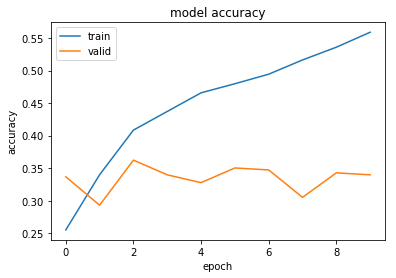

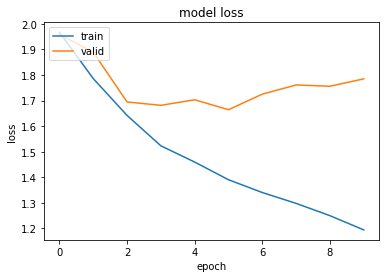

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
y_pred = model.predict_proba(test_set)

5024/5668 [=========================>....] - ETA: 0s

In [35]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_keras_nn.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.001784,0.297470,0.010421,0.001337,0.014144,0.046862,0.625325,0.001628,0.001030,0
1,0.357812,0.011632,0.022059,0.465233,0.045530,0.074012,0.011577,0.003275,0.008870,1
2,0.268194,0.087023,0.041406,0.189572,0.071889,0.119281,0.203000,0.007483,0.012151,2
3,0.006903,0.276400,0.009976,0.007970,0.009507,0.008518,0.676994,0.002000,0.001731,3
4,0.158533,0.000133,0.001092,0.836175,0.002009,0.001789,0.000143,0.000017,0.000109,4


In [37]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [38]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

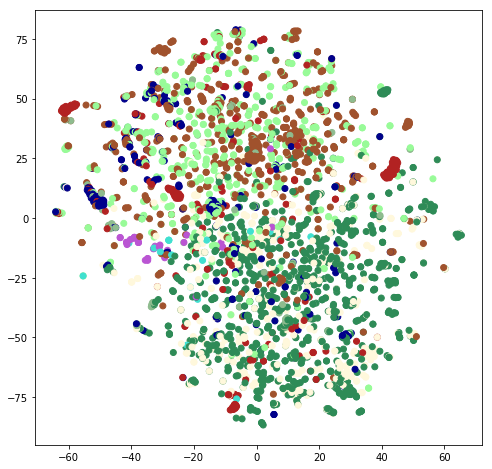

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()